In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [77]:
class Delay(nengo.synapses.Synapse):
    def __init__(self, delay, size_in=1):
        self.delay = delay
        super().__init__(default_size_in=size_in, default_size_out=size_in)

    def make_state(self, shape_in, shape_out, dt, dtype=None, y0=None):
        return {}

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        steps = int(self.delay/dt)
        print('steps', steps)
        if steps == 0:
            def step_delay(t, x):
                return x
            return step_delay
        assert steps > 0

        state = np.zeros((steps, shape_in[0]))
        state_index = np.array([0])

        def step_delay(t, x, state=state, state_index=state_index):
            result = state[state_index]
            state[state_index] = x
            state_index[:] = (state_index + 1) % state.shape[0]
            return result

        return step_delay

In [284]:
import nengo_spa as spa
import nengo
import gym
import logging
gym.logger.set_level(logging.ERROR)  # suppress the error of running the model after it's done
import numpy as np
import pytry

class CartPoleTrial(pytry.PlotTrial):
    def params(self):
        self.param('time to run', T=10)
        self.param('gate error signal', gate_error=False)
        self.param('gate future value signal', gate_future_value=False)
        self.param('RL discount rate', gamma=0.9)
        self.param('use SSP representation', use_ssp=False)
        self.param('number of neurons', n_neurons=1000)
        self.param('learning rate', learning_rate=1e-4)
        self.param('SSP scale', ssp_scale=1)
        self.param('normalize state', normalize_state=False)
        self.param('sample encoders from represented space', sample_encoders=False)
        self.param('multiplicative SSP', ssp_multiply=False)
        self.param('cosine intercepts', cosine_intercepts=False)
        
    def evaluate(self, p, plt):
        # define the OpenAI gym environment interface
        class CartPole:
            def __init__(self, done_time=20, reset_time=20, seed=None):
                self.rng = np.random.RandomState(seed=seed)
                
                self.state = self.rng.choice([0,1])
                self.reset_time = reset_time
                self.done_time = done_time
                self.reset_counter = 0
                if p.normalize_state:
                    self.state_scale = 1.0/np.array([0.22055888, 0.70636221, 0.44982735, 1.8954963])
                else:
                    self.state_scale = np.ones(4)
                    
            def update(self, t, x):
                action = 0 if x[0]==1 else 1
                if action == self.state:
                    reward = 1
                else:
                    reward = -1
                self.state = self.rng.choice([0,1])
                
                return [[-1,1][self.state], 0, 0, 0, reward, 0]
        
        # choose the style of representation to use
        if p.use_ssp:
            D = 128
            vocab = spa.Vocabulary(D)
            X = vocab.create_pointer().unitary().v
            DX = vocab.create_pointer().unitary().v
            A = vocab.create_pointer().unitary().v
            DA = vocab.create_pointer().unitary().v
            
            def power(s, e):
                return np.fft.ifft(np.fft.fft(s) ** e).real
            def circ_conv(a, b):
                return np.fft.ifft(np.fft.fft(a) * np.fft.fft(b)).real
            
            

            if p.ssp_multiply:
                def convert(x):
                    return circ_conv(circ_conv(power(X, x[0]*p.ssp_scale),power(DX, x[1])) , circ_conv(power(A, x[2]*p.ssp_scale),power(DA, x[3])))
            else:
                def convert(x):
                    return power(X, x[0]*p.ssp_scale) + power(DX, x[1]) + power(A, x[2]*p.ssp_scale) + power(DA, x[3])
        else:
            def convert(x):
                return x
            

        # define the nengo model
        env = CartPole(seed=p.seed)
        model = nengo.Network()
        with model:
            cp = nengo.Node(env.update, size_in=2, size_out=6)
            p_env = nengo.Probe(cp)

                
            #ns = nengo.Ensemble(n_neurons=p.n_neurons, 
            #                    dimensions=D if p.use_ssp else 4,
            #                    radius=1 if p.use_ssp else 2,
            #                    neuron_type=nengo.RectifiedLinear())
            
            ens = nengo.Ensemble(n_neurons=2,
                                dimensions=4,
                                encoders=[[1,0,0,0], [-1,0,0,0]],
                                 intercepts=[0.5,0.5],
                                 max_rates=[100,100],
                                 neuron_type=nengo.RectifiedLinear())
            
            
            if p.use_ssp and p.sample_encoders:
                encoders = []
                for i in range(ens.n_neurons):
                    x = np.random.uniform(-1, 1, size=4)
                    e = convert([x[0]*2, x[1]*2, x[2]*2, x[3]*2])
                    encoders.append(e)
                ens.encoders = np.array(encoders)
                
              
            if p.cosine_intercepts:
                ens.intercepts = nengo.dists.CosineSimilarity(ens.dimensions+2)
            #ens.intercepts=nengo.dists.Uniform(-0.5, 1)
            nengo.Connection(cp[:4], ens, function=convert, synapse=None)
                
            v = nengo.Node(None, size_in=1)
            c = nengo.Connection(ens.neurons, v, transform=np.zeros((1, ens.n_neurons)), 
                                 learning_rule_type=nengo.PES(learning_rate=p.learning_rate, pre_synapse=0),
                                 synapse=None)


            error = nengo.Node(None, size_in=1)
            nengo.Connection(cp[4], error, transform=-1, synapse=0)
            nengo.Connection(v, error, transform=1, synapse=0)

            if p.gate_future_value:
                gated_value = nengo.Node(lambda t, x: x[0] if (x[1]==0) else 0, size_in=2, size_out=1)
                nengo.Connection(v, gated_value[0], synapse=None)
                nengo.Connection(cp[5], gated_value[1], synapse=None)
                nengo.Connection(gated_value, error, transform=-p.gamma, synapse=None)
            else:
                nengo.Connection(v, error, transform=-p.gamma, synapse=None)

            if p.gate_error:
                gate = nengo.Node(lambda t, x: x[0] if (x[1]==0) else 0, size_in=2, size_out=1)
                nengo.Connection(error, gate[0], synapse=None)
                nengo.Connection(cp[5], gate[1], synapse=None)
                nengo.Connection(gate, c.learning_rule, transform=1, synapse=None)
            else:
                nengo.Connection(error, c.learning_rule, transform=1, synapse=None)

            p_v = nengo.Probe(v)
            
            tau_fast = None
            tau_slow = 0
            # the raw output from the network
            raw_actions = nengo.Node(None, size_in=2, label='raw_actions')

            # compute the softmax
            def softmax(t, x):
                scale = 10
                #try:
                return np.exp(x*scale)/np.sum(np.exp(x*scale))
                #except FloatingPointError:
                #    return np.eye(len(x))[0]
            actions = nengo.Node(softmax, size_in=2, label='actions')
            nengo.Connection(raw_actions, actions, synapse=None)

            # do the random sampling and output which action we're taking
            #  (here I just decided to represent choosing the action as +1 and not choosing as -1)
            def choice_func(t, x):
                c = np.random.choice(np.arange(2), p=x)
                #c = 0
                result = [-1, -1]
                result[c] = 1
                return result
            choice = nengo.Node(choice_func, size_in=2, size_out=2, label='choice')
            nengo.Connection(actions, choice, synapse=None)

            # and now connect the choice to the environment
            nengo.Connection(choice, cp, synapse=0)

            # and here is the computation of the error signal
            c_actor = nengo.Connection(ens.neurons, raw_actions, transform=np.zeros((2, ens.n_neurons)), 
            #c_actor = nengo.Connection(ens, raw_actions, function=lambda x: [1,-1] if x[0]<0.5 else [-1,1], 
                                       learning_rule_type=nengo.PES(learning_rate=1e-5, pre_synapse=Delay(0.02)),
                                       synapse=None)

            # implement the advantage actor-critic error rule
            #  the Node gets 5 inputs: the delta for the critic part, 2 values indicating which action was chosen
            #  (+1 for the chosen and -1 for the non-chosen ones), and the choice probabilities for the 2 actions
            def actor_error_func(t, x):
                delta = x[0]
                chosen = x[1:3]
                prob = x[3:5]
                # compute the error
                e = np.where(chosen>0, delta*(1-prob), -delta*prob)
                # = np.where(chosen>0, delta, -delta)
                
                if t<10:
                    e = e * 0
                return e

            actor_error = nengo.Node(actor_error_func, size_in=5, label='actor_error')
            nengo.Connection(error, actor_error[0], synapse=None)
            nengo.Connection(choice, actor_error[1:3], synapse=None)
            nengo.Connection(actions, actor_error[3:5], synapse=None)
            nengo.Connection(actor_error, c_actor.learning_rule, transform=-1, synapse=None) 
            
            p_raw_actions = nengo.Probe(raw_actions)
            p_prob = nengo.Probe(actions)
            p_error = nengo.Probe(error)
            p_actor_error = nengo.Probe(actor_error)
            p_choice = nengo.Probe(choice)
            p_ens = nengo.Probe(ens)

            
            
            

        # run the model
        sim = nengo.Simulator(model, dt=0.01)
        sim.run(p.T)
        
        # make the summary plot, if asked
        if plt:
            v = sim.data[p_v]
            
            #plt.plot(v)
            plt.subplot(3, 1, 1)
            plt.plot(sim.data[p_ens])
            #plt.plot(sim.data[p_raw_actions], label='raw')
            #plt.plot(sim.data[p_prob], label='prob')
            plt.legend()
            plt.subplot(3, 1, 2)
            plt.plot(sim.data[p_env][:,0], label='state')
            plt.plot(sim.data[p_env][:,4], label='reward', lw=3)
            plt.plot(sim.data[p_error], label='critic error')
            plt.plot(sim.data[p_v], label='predicted value')
            plt.legend()
            
            plt.subplot(3, 1, 3)
            #plt.plot(sim.data[p_choice], label='choice')
            #plt.plot(sim.data[p_actor_error], label='actor error')
            plt.plot(sim.data[p_raw_actions], label='raw actions')
            
            plt.legend()
            
            
            
        # return the raw environment data and the decoded value
        return dict(v=sim.data[p_v], env=sim.data[p_env], 
                    raw_actions=sim.data[p_raw_actions], prob=sim.data[p_prob], model=model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

steps 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

No handles with labels found to put in legend.


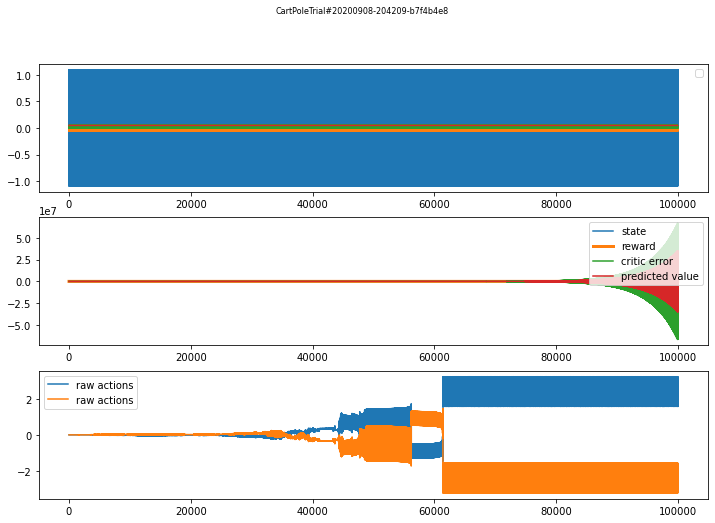

In [292]:
plt.figure(figsize=(12,8))
r = CartPoleTrial().run(data_dir=None, verbose=False, T=1000, plt=plt, use_ssp=False, ssp_scale=10, 
                        sample_encoders=False, cosine_intercepts=False, learning_rate=1e-5, gamma=0.9, seed=1)

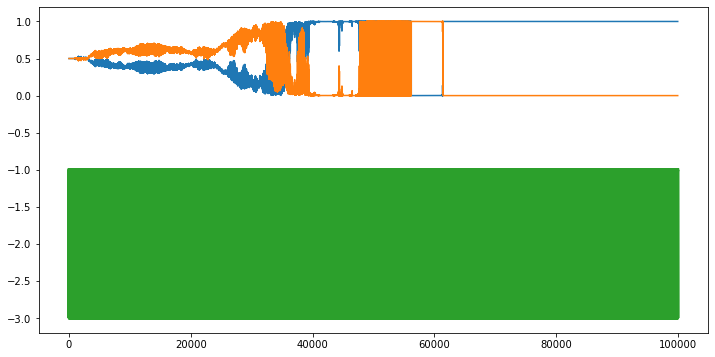

In [293]:
plt.figure(figsize=(12,6))
plt.plot(r['prob'])
plt.plot(r['env'][:,0]-2, label='reset', lw=3)


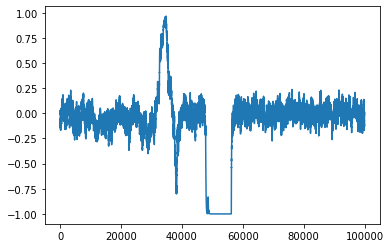

In [294]:

plt.plot(nengo.synapses.Lowpass(0.1).filt(r['env'][:,4]))

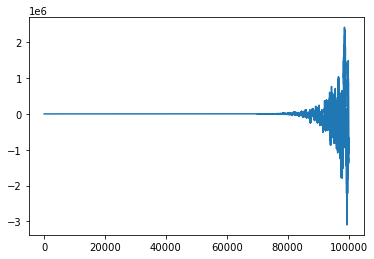

In [288]:
plt.plot(nengo.synapses.Lowpass(0.1).filt(r['v']))
#plt.xlim(40000,60000)
#plt.ylim(-100,100)

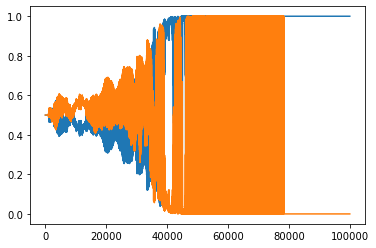

In [266]:
plt.plot(r['prob'])